#LIBRARIES AND LINK TO GDRIVE

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback, CSVLogger
from fastai.metrics import top_k_accuracy
from pathlib import Path
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
from scipy.ndimage.filters import gaussian_filter
from matplotlib.patheffects import Stroke, Normal
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import accumulate 
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
gpu = torch.device('cuda:0')

#DEFINITIONS OF CLASSES AND METHODS

In [5]:
def numericalize_tokens(tok):
    return np.array([vocabolary.numericalize(q) + [1] for q in tok])

def build_data(fns_caps, PATH, name):
    filenames, captions = zip(*fns_caps)
    filenames = list(map(lambda x: "/content/gdrive/My Drive/App/Flickr_Data/Images_30k/flickr30k_images/flickr30k_images" +"/" + x,filenames))
    captions_tok = list()
    print(len(captions))
    i=0
    for c in captions:
        i=i+1
        print(i)
        captions_tok.append(numericalize_tokens(tokenizer.process_all(c)))
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(str(PATH)+"/"+name+".pkl", 'wb'))

def build_art_data(fns_caps, PATH, name):
    filenames, captions = zip(*fns_caps)
    filenames = list(map(lambda x: "/content/gdrive/My Drive/App/Art_Dataset" +"/" + x,filenames))
    captions_tok = list()
    print(len(captions))
    i=0
    for c in captions:
        i=i+1
        print(i)
        captions_tok.append(numericalize_tokens(tokenizer.process_all(c)))
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(str(PATH)+"/"+name+"_art.pkl", 'wb'))

def build_artpedia_data(fns_caps, PATH, name):
    filenames, captions = zip(*fns_caps)
    filenames = list(map(lambda x: "/content/gdrive/My Drive/App/Art_Dataset/artpedia/artpedia_google_images/"+name+"/"+ x,filenames))
    captions_tok = list()
    print(len(captions))
    i=0
    for c in captions:
        i=i+1
        print(i)
        captions_tok.append(numericalize_tokens(tokenizer.process_all(c)))
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(str(PATH)+"/artpedia/"+name+".pkl", 'wb'))

class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
          data (tuple): Contains a list of filenames and a list of tokenized and numericalized captions
          transforms (callable, optional): Optional transforms to be applied
        """
        self.filenames = data[0]
        self.captions  = data[1]
        self.transform = transform
        self.mult_captions_per_image = not isinstance(train_data[1][0][0], int)
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # Grayscale images in dataset have to be onverted as tensor shapes have to match except in dim=0
        image = Image.open(self.filenames[idx]).convert('RGB')
        if self.mult_captions_per_image:
            caption = self.captions[idx][random.randint(0, len(self.captions[idx]) - 1)]
        else:
            caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption)

def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return (torch.stack(images, 0, out=None), res_cap), res_cap



In [6]:
def fc_layer(n_in, n_out, p=0.1):
    return nn.Sequential(
        Flatten(),
        nn.Linear(in_features=n_in, out_features=n_out),
        nn.Dropout(p),
    )

class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            fc_layer(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
          
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

class Encoder50(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            fc_layer(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
          
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)  # Equation (4) in Xu et al. (2015)
        
    def forward(self, annotation_vecs, dec_hid_state):
        #pdb.set_trace()
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)  # Eq. 4
        alphas = F.softmax(e, dim=1)  # Equation (5) in Xu et al. (2015)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)  # Equations (13)
        
        return context_vec, alphas

class ImageCaptionGenerator(nn.Module):
    def __init__(self, device, filter_width, num_filters, vocab_size, emb_sz, out_seqlen, n_layers=3, prob_teach_forcing=1, p_drop=0.3):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = nn.Embedding(vocab_size, emb_sz) #create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, dropout=0 if n_layers == 1 else p_drop)  # square to enable weight tying
        self.out_drop = nn.Dropout(p_drop)
        self.out = nn.Linear(emb_sz, vocab_size)
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)  # Section 4.2.1 in Xu et al. (2015)
        
        self.prob_teach_forcing = prob_teach_forcing
        self.initializer()
        
    def initializer(self):
        self.emb.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, y=None):
        #pdb.set_trace()
        h, annotation_vecs = self.encode(x)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            #pdb.set_trace()
            dec_output, h, alpha = self.decode_step(dec_inp, h, annotation_vecs)
            res.append(dec_output)
            alphas.append(alpha)
            
            if (dec_inp == 1).all() or (y is not None and i >= len(y)):
                break            
            # teacher forcing
            elif y is not None and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                dec_inp = y[i].to(self.device)
            else:
                dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax

        return torch.stack(res), torch.stack(alphas)
    
    def encode(self, x):
        return self.encoder(x.to(self.device))
    
    def decode_step(self, dec_inp, h, annotation_vecs):
        #pdb.set_trace()
        context_vec, alpha = self.att(annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec  # Section 4.2.1 in Xu et al. (2015)
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h, alpha

class TeacherForcingCallback(Callback):
    def __init__(self, learn:Learner, decay_epochs=45):
        super().__init__()
        self.learn = learn
        self.decay_iterations = decay_epochs * len(self.learn.data.train_ds) // self.learn.data.batch_size
    
    def on_batch_begin(self, iteration: int, **kwargs: Any) -> None:
        self.learn.model.prob_teach_forcing = (self.decay_iterations-iteration) * 1/self.decay_iterations if iteration < self.decay_iterations else 0

def ImageCaptionLoss(pred, target, lamb = 1):
    #pdb.set_trace()
    pred, alphas = pred
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    loss = F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))
    
    # See section 4.2.1 "Doubly stocastic attention"
    penalty = ((1. - alphas.sum(0)) ** 2.).mean()
    # ((1. - alphas.sum(0)) ** 2.).sum(1).mean()

    return loss + lamb * penalty

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_outline(matplt_plot_obj, lw):
    matplt_plot_obj.set_path_effects([Stroke(linewidth=lw, foreground='black'), Normal()])

def show_img(im, figsize=None, ax=None, alpha=1, cmap=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
    
def visualize_attention(im, pred, alphas, denorm, vocab, att_size=7, thresh=0., sz=224, return_fig_as_PIL_image=False):
    cap_len = len(pred)
    alphas = alphas.view(-1,1,  att_size, att_size).cpu().data.numpy()
    alphas = np.maximum(thresh, alphas)
    alphas -= alphas.min()
    alphas /= alphas.max()
 
    figure, axes = plt.subplots(cap_len//5 + 1,5, figsize=(12,8))
 
    for i, ax in enumerate(axes.flat):
        if i <= cap_len:
            ax = show_img(denorm(im), ax=ax)
            if i > 0:
                mask = np.array(Image.fromarray(alphas[i - 1,0]).resize((sz,sz)))
                blurred_mask = gaussian_filter(mask, sigma=8)
                show_img(blurred_mask, ax=ax, alpha=0.5, cmap='afmhot')
                draw_text(ax, (0,0), vocab.itos[pred[i - 1]])
        else:
            ax.axis('off')
    plt.tight_layout()

    if return_fig_as_PIL_image:
        return fig2img(figure)

In [7]:
from nltk.translate.bleu_score import corpus_bleu

class BleuMetric(Callback):
    def on_epoch_begin(self, **kwargs):
        self.references = list()
        self.candidates = list()
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        #pdb.set_trace()
        num_sentences = last_output[0].size(1)
        cands = last_output[0].data.max(2)[1].transpose(1,0).chunk(num_sentences, 0)
        refs = last_target.transpose(1,0).chunk(num_sentences, 0)
        
        self.candidates.extend([[tok for tok in c[0].cpu().numpy() if tok != 1] for c in cands])
        self.references.extend([[[tok for tok in r[0].cpu().numpy() if tok != 1]] for r in refs])
        
    def on_epoch_end(self, last_metrics, **kwargs):
        #pdb.set_trace()
        assert len(self.references) == len(self.candidates)
        return add_metrics(last_metrics, corpus_bleu(self.references, self.candidates))

In [8]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)


def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()

        
    return lr_to_use

In [9]:
class HypothesisNode():
    """ Hypothesis Node class for performing Beam Search """
    def __init__(self, sequence, log_prob, hidden_state, alphas):
        """HypothesisNode constructur
        
        Args:
          sequence: A sequence of tokens
          log_prob: The log of the probability of this sequence
          hidden_state: The hidden state of the Decoder RNN after decoding the last token in the sequence
        """
        self._seq = sequence
        self._alphas = alphas
        self._log_prob = log_prob
        self._h = hidden_state
    
    @property
    def last_tok(self):
        """
        Returns:
          The last token in the sequence
        """
        return self._seq[-1]
        
    def update(self, tok, log_prob, new_h, new_alpha):
        """
        Updates the sequence with a new token and returns a new Hypothesis Node
        Args:
          tok: The new token that is appended to the sequence
          log_prob: The log of the probability ot this token
          new_h: The new hidden state of the Decoder RNN after this token
        
        Returns:
          An Hypothesis Node with the updated sequence, log probability and hidden state
        """
        return HypothesisNode(self._seq + [tok], self._log_prob + log_prob, new_h, self._alphas + new_alpha)
    
    def __str__(self):
        print(vocab.itos)
        return ('Hyp(log_p = %4f,\t seq = %s)' % (self._log_prob, vocab.textify([t.item()for t in self._seq])))

class BeamSearch():
    """ Performs BeamSearch for seq2seq decoding or Image captioning """
    def __init__(self, enc_model, dec_model, beam_width=5, num_results=1, max_len=30, device=torch.device('cuda:0')):
        """BeamSearch object constructor
        Args:
          enc_model: A seq2seq encoder or cnn for image captioning
          dec_model: A RNN decoder model
          beam_width: int, the number of hypotheses to remember in each iteration
          max_len: int, the longest possible sequence
        """
        self._device = device
        self._enc_model = enc_model
        self._dec_model = dec_model
        self._beam_width = beam_width
        self._num_results = num_results
        self._max_len = max_len
        self._start_tok = 0
        self._end_tok   = 1
        self._annotation_vecs = None
        
    def __call__(self, img, verbose=False):
        """Performs the Beam search
        Args:
          img: the image to be annotated, torch tensor with 3 color channels
          verbose: bool, allows printing the intermediate hypotheses for better understanding
        
        Returns:
          The 'beam_width' most probable sentences
        """
        img = img.unsqueeze(0)
        h, annotation_vecs = self._enc_model(img)
        self._annotation_vecs = annotation_vecs
        
        hyps = [HypothesisNode([torch.zeros(1, requires_grad=False).long().to(self._device)], 0, h, [])]
        results = []
        
        step = 0
        width = self._beam_width
        while width > 0 and step < self._max_len:
            if verbose: print("\n Step: ",step)
            new_hyps = []
            for h in hyps:
                new_hyps.extend(self.get_next_hypotheses(h, width))
            
            new_hyps = sorted(new_hyps, key= lambda x: x._log_prob, reverse=True)
            if verbose: self.print_hypotheses(new_hyps, "Before narrowing:")
                
            hyps = []
            for h in new_hyps[:width]:
                if h.last_tok == self._end_tok:
                    results.append(h)
                    width = width - 1
                else:
                    hyps.append(h)
            
            if verbose: 
                self.print_hypotheses(hyps, "After narrowing:")
                self.print_hypotheses(results, "Results:")
                
            step += 1
         
        results.extend(hyps[:width])
        results = sorted(results, key=lambda x: x._log_prob/len(x._seq), reverse=True)
        
        if verbose: self.print_hypotheses(results, "Final:")
        
        if self._num_results == 1:
            return ([t.item() for t in results[0]._seq[1:-1]], torch.stack(results[0]._alphas))
        else:
            return [([t.item() for t in r._seq[1:-1]], torch.stack(r._alphas)) for r in results[:self._num_results]]
        
    def get_next_hypotheses(self, hyp, k):
        """Calculates the next 'beam_width' hypotheses given a Hypothesis Node
        Args:
          hyp: an Hypothesis Node containing a sequence, a log probability and a Decoder RNN hidden state
          k: the number of hypotheses to calculate
        Returns:
          A list with the 'beam_width' most probable sequences/Hypothesis Nodes
        """

        dec_outp, h, alphas = self._dec_model(hyp.last_tok, hyp._h, self._annotation_vecs)

        top_k_log_probs, top_k_toks = dec_outp.topk(k, dim=1)

        return [hyp.update(top_k_toks[0][i].unsqueeze(0), top_k_log_probs[0][i], h, list(alphas)) for i in range(k)]
    
    def print_hypotheses(self, hyps, description):
        print(description)
        for h in hyps:
            print(h)

#PREPARATION OF DATASETS

1) Load json file and separate datas in train, valid and test

In [10]:
PATH = Path('/content/gdrive/My Drive/App/ms_coco_data/')
ART_PATH = Path('/content/gdrive/My Drive/App/Art_Dataset/')
PATH.mkdir(exist_ok=True)

VALID_PATH = PATH/"valid"
VALID_PATH.mkdir(exist_ok=True)
TRAIN_PATH= PATH/"train"
TRAIN_PATH.mkdir(exist_ok=True)

dataset_json = json.load((PATH/'dataset_flickr30k.json').open())
art_dataset_json = json.load((ART_PATH/'Art_Dataset.json').open())

train = [d for d in dataset_json["images"] if d["split"] in {"train", "restval"}]
test  = [d for d in dataset_json["images"] if d["split"] == "test"]
valid = [d for d in dataset_json["images"] if d["split"] == "val"]
art_train = [d for d in art_dataset_json["images"] if d["split"] in {"train", "restval"}]
art_test  = [d for d in art_dataset_json["images"] if d["split"] == "test"]
art_valid = [d for d in art_dataset_json["images"] if d["split"] == "val"]


train_fns_caps = [(d["filename"], [c["raw"] for c in d["sentences"]]) for d in train]
test_fns_caps  = [(d["filename"], [c["raw"] for c in d["sentences"]]) for d in test]
valid_fns_caps = [(d["filename"], [c["raw"] for c in d["sentences"]]) for d in valid]
art_train_fns_caps = [(d["filename"], [c["raw"] for c in d["sentences"]]) for d in art_train]
art_test_fns_caps  = [(d["filename"], [c["raw"] for c in d["sentences"]]) for d in art_test]
art_valid_fns_caps = [(d["filename"], [c["raw"] for c in d["sentences"]]) for d in art_valid]

artpedia_dataset_json = json.load((ART_PATH/'artpedia/artpedia.json').open())

total = [artpedia_dataset_json.get(d) for d in artpedia_dataset_json]
length_to_split = [2344, 586]
artpedia_train, artpedia_valid = [total[x - y: x] for x, y in zip( 
          accumulate(length_to_split), length_to_split)] 


In [ ]:
titles = [d["title"] for d in artpedia_train]
years = [str(d["year"]) for d in artpedia_train]

In [ ]:
import string

for s in range (0, len(titles)):
  exclude = set(string.punctuation)
  titles[s] = ''.join(ch for ch in titles[s] if ch not in exclude)

In [ ]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git

  Cloning https://github.com/Joeclinton1/google-images-download.git to /tmp/pip-req-build-iubjsigp
  Running command git clone -q https://github.com/Joeclinton1/google-images-download.git /tmp/pip-req-build-iubjsigp
     |████████████████████████████████| 911kB 10.9MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=15793 sha256=16c46fe72b4fb086e422e7fb8fccbb8e38323d2241640ffb2e1b68531a230fd9
  Stored in directory: /tmp/pip-ephem-wheel-cache-3_o6d9_y/wheels/1a/36/c9/53bd827bc241b69fe47b90731625459627f82694ecd8a88273
Successfully built google-images-download


In [ ]:
from google_images_download import google_images_download
from termcolor import colored

for i in range (0, len(titles)):
  print(colored(str(i), 'red'))
  response = google_images_download.googleimagesdownload()
  arguments = {"keywords":titles[i],"limit":1,"print_urls":True,
               "output_directory":'/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/train2',
               "format":"jpg", "size": "medium"}
  paths = response.download(arguments)
  for path in pathlib.Path('/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/train2/'+titles[i]).iterdir():
    if path.is_file():
        old_name = path.stem
        old_extension = path.suffix
        directory = path.parent
        new_name = str(i)+'.jpg'
        path.rename(pathlib.Path(directory, new_name))
  os.replace('/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/train2/'+ titles[i]+'/'+str(i)+'.jpg', '/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/train2/'+str(i)+".jpg")
  os.rmdir('/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/train2/'+titles[i])


In [ ]:
titles = [d["title"] for d in artpedia_valid]
years = [str(d["year"]) for d in artpedia_valid]

for s in range (0, len(titles)):
  exclude = set(string.punctuation)
  titles[s] = ''.join(ch for ch in titles[s] if ch not in exclude)

In [ ]:
for i in range (0, len(titles)):
  print(colored(str(i), 'red'))
  response = google_images_download.googleimagesdownload()
  arguments = {"keywords":titles[i],"limit":1,"print_urls":True,
               "output_directory":'/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/valid2',
               "format":"jpg"}
  paths = response.download(arguments)
  for path in pathlib.Path('/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/valid2/'+titles[i]).iterdir():
    if path.is_file():
        old_name = path.stem
        old_extension = path.suffix
        directory = path.parent
        new_name = str(i)+'.jpg'
        path.rename(pathlib.Path(directory, new_name))
  os.replace('/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/valid2/'+ titles[i]+'/'+str(i)+'.jpg', '/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/valid2/'+str(i)+".jpg")
  os.rmdir('/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/valid2/'+titles[i])


In [ ]:
# imageFolder = '/content/gdrive/MyDrive/App/Art_Dataset/artpedia/artpedia_google_images/train'
# listImages = os.listdir(imageFolder)

# for img in listImages:
#     imgPath = os.path.join(imageFolder,img)
            
#     try:
#         img = Image.open(imgPath)
#         exif_data = img._getexif()
#     except ValueError as err:
#         print(err)
#         print("Error on image: ", img)

In [ ]:
artpedia_train_fns_caps = [(str(d)+".jpg", [c for c in artpedia_train[d]["visual_sentences"]]) for d in range(0, len(artpedia_train))]
artpedia_valid_fns_caps = [(str(d)+".jpg", [c for c in artpedia_valid[d]["visual_sentences"]]) for d in range(0, len(artpedia_valid))]

In [ ]:
import string
import re

for d in artpedia_train_fns_caps:
  print("-------------------")
  s = 0
  while s < len(d[1]):
    print(str(s+1)+"/"+str(len(d[1])))
    exclude = set(string.punctuation)
    # d[1][s] = ''.join([i for i in d[1][s] if not i.isdigit()])
    d[1][s] = ''.join(ch for ch in d[1][s] if ch not in exclude)
    d[1][s] = d[1][s].replace('Virgin', 'virgin')
    d[1][s] = d[1][s].replace('Christ', 'christ')
    # print(s)
    found = False
    for char in range (1, len(d[1][s])):
      # print(s[char])
      if d[1][s][char].isupper() or d[1][s][char].isdigit():
        # print("UPPER")
        found = True
    if (found and len(d[1]) > 1):
      # print("deleted"+str(count))
      d[1].pop(s)
      s-=1
    s+=1

In [ ]:
artpedia_train_fns_caps[6]

('6.jpg',
 ['The painting has a traditional christian subject representing the virgin Mary and the christ Child seated on her lap with saints and angels surrounding them on all sides'])

In [ ]:
for d in artpedia_valid_fns_caps:
  print("-------------------")
  s = 0
  while s < len(d[1]):
    print(str(s+1)+"/"+str(len(d[1])))
    exclude = set(string.punctuation)
    # d[1][s] = ''.join([i for i in d[1][s] if not i.isdigit()])
    d[1][s] = ''.join(ch for ch in d[1][s] if ch not in exclude)
    d[1][s] = d[1][s].replace('Virgin', 'virgin')
    d[1][s] = d[1][s].replace('Christ', 'christ')
    # print(s)
    found = False
    for char in range (1, len(d[1][s])):
      # print(s[char])
      if d[1][s][char].isupper() or d[1][s][char].isdigit():
        # print("UPPER")
        found = True
    if (found and len(d[1]) > 1):
      # print("deleted"+str(count))
      d[1].pop(s)
      s-=1
    s+=1

2) Tokenize and numericalize captions 

In [ ]:
tokenizer = Tokenizer(n_cpus=1)
train_captions_tokenized = tokenizer.process_all(
    list(itertools.chain.from_iterable(list(zip(*train_fns_caps))[1]))
)

vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)
pickle.dump(vocab, open(PATH/"vocab.pkl", 'wb'))

In [ ]:
tokenizer = Tokenizer(n_cpus=1)
train_captions_tokenized = tokenizer.process_all(
    list(itertools.chain.from_iterable(list(zip(*art_train_fns_caps))[1]))
)

art_vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)
pickle.dump(art_vocab, open(PATH/"art_vocab.pkl", 'wb'))

In [ ]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))
art_vocab = pickle.load((PATH/"art_vocab.pkl").open('rb'))
# len(art_vocab.itos)
len(vocab.itos)

11768

In [11]:
tokenizer = Tokenizer(n_cpus=1)
train_captions_tokenized = tokenizer.process_all(
    list(itertools.chain.from_iterable(list(zip(*art_train_fns_caps))[1]))+list(itertools.chain.from_iterable(list(zip(*train_fns_caps))[1]))
)

total_vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)
pickle.dump(total_vocab, open(PATH/"total_vocab.pkl", 'wb'))
vocabolary = pickle.load((PATH/"total_vocab.pkl").open('rb'))
len(vocabolary.itos)

11816

In [ ]:
tokenizer = Tokenizer(n_cpus=1)
train_captions_tokenized = tokenizer.process_all(
    list(itertools.chain.from_iterable(list(zip(*artpedia_train_fns_caps))[1]))+list(itertools.chain.from_iterable(list(zip(*artpedia_valid_fns_caps))[1]))
)

total_vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=1)
pickle.dump(total_vocab, open(PATH/"artpedia_total_vocab.pkl", 'wb'))
vocabolary = pickle.load((PATH/"artpedia_total_vocab.pkl").open('rb'))
len(vocabolary.itos)

13032

In [ ]:
print(vocabolary.itos)

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', 'a', 'of', 'and', 'in', 'is', 'to', 'with', 'on', 'her', 'by', 'his', 'painting', 'are', 'an', 'it', 'as', 'left', 'at', 'right', 'from', 'which', 'two', 'she', 'he', 'shows', 'that', 'woman', 'background', 'depicts', 'for', 'man', 'one', 'hand', 'has', 'be', 'or', 'was', 'white', 'while', 'young', 'red', 'black', 'this', 'figures', 'who', 'landscape', 'foreground', 'head', 'their', 'other', 'behind', 'but', 'over', 'also', 'its', 'portrait', 'wears', 'scene', 'figure', 'light', 'him', 'dark', 'saint', 'christ', 'three', 'out', 'painted', 'dress', 'holds', 'into', 'seen', 'oil', 'blue', 'shown', 'holding', 'work', 'face', 'child', 'been', 'artist', 'have', 'table', '\n ', 'back', 'side', 'large', 'hair', 'both', 'canvas', 'against', 'dressed', 'sky', 'small', 'stands', 'some', 'they', 'women', 'not', 'through', 'above', 'trees', 'up', 'around', 'can', 'wearing', 'there', 'paintings', 'mary', 'hat',

In [ ]:
%time build_data(train_fns_caps, PATH, "train")
%time build_data(test_fns_caps, PATH, "test")
%time build_data(valid_fns_caps, PATH, "valid")

In [ ]:
%time build_art_data(art_train_fns_caps, ART_PATH, "art_train")
# %time build_art_data(art_test_fns_caps, PATH, "art_test")
%time build_art_data(art_valid_fns_caps, ART_PATH, "art_valid")

In [ ]:
%time build_artpedia_data(artpedia_train_fns_caps, ART_PATH, "train")
%time build_artpedia_data(artpedia_valid_fns_caps, ART_PATH, "valid")

In [12]:
valid_data = pickle.load((PATH/"valid.pkl").open('rb'))
test_data  = pickle.load((PATH/"test.pkl").open('rb'))
train_data = pickle.load((PATH/"train.pkl").open('rb'))

art_valid_data = pickle.load((ART_PATH/"art_valid_art.pkl").open('rb'))
art_train_data = pickle.load((ART_PATH/"art_train_art.pkl").open('rb'))

artpedia_valid_data = pickle.load((ART_PATH/"artpedia/valid.pkl").open('rb'))
artpedia_train_data = pickle.load((ART_PATH/"artpedia/train.pkl").open('rb'))

In [ ]:
artpedia_train_data[1][10]

array([list([5, 9, 1132, 14, 3360, 29, 681, 29, 9, 208, 11, 9, 2528, 11, 2026, 148, 109, 199, 15, 3361, 9, 682, 28, 544, 1]),
       list([5, 9, 148, 608, 34, 10, 609, 5071, 231, 641, 12, 610, 917, 1446, 1]),
       list([5, 117, 190, 17, 10, 393, 14, 185, 27, 9, 331, 35, 32, 14, 3362, 75, 11, 18, 344, 2529, 16, 10, 1447, 12, 764, 5072, 165, 16, 1678, 27, 9, 1448, 2027, 1]),
       list([5, 18, 77, 43, 23, 5073, 641, 1]),
       list([5, 27, 9, 446, 9, 31, 2028, 207, 11, 9, 1282, 22, 1283, 19, 9, 179, 67, 19, 31, 3363, 2029, 683, 1])],
      dtype=object)

In [ ]:
figure, axes = plt.subplots(5//5 + 1,5, figsize=(24,16))
 
for i, ax in enumerate(axes.flat):
        ax = show_img(denorm(train_tfms(Image.open(art_valid_data[0][0]).convert('RGB'))), ax=ax)
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
sz=224

train_tfms = transforms.Compose([
    # transforms.RandomResizedCrop(sz, scale=(0.2,1.0)),
    transforms.Resize(sz),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=2, fill=0),
    # transforms.RandomRotation(10, expand=False),
    transforms.CenterCrop(sz),
    # transforms.RandomCrop(224),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ColorJitter(brightness=0.4, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

valid_tfms = transforms.Compose([
    transforms.Resize(sz),
    transforms.CenterCrop(sz),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)

# To denormalize images
denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

3) Creation of Dataloader

In [14]:
valid_dataset = ImageCaptionDataset(valid_data, transform=valid_tfms)
train_dataset = ImageCaptionDataset(train_data, transform=valid_tfms)

art_valid_dataset = ImageCaptionDataset(art_valid_data, transform=valid_tfms)
art_train_dataset = ImageCaptionDataset(art_train_data, transform=valid_tfms)

artpedia_valid_dataset = ImageCaptionDataset(artpedia_valid_data, transform=valid_tfms)
artpedia_train_dataset = ImageCaptionDataset(artpedia_train_data, transform=valid_tfms)

In [15]:
bs=80
art_bs=50
imgcap_collate_func = partial(pad_collate_ImgCap, pad_first=False, transpose=True)

val_sampler = SortSampler(valid_data[1], key=lambda x: len(valid_data[1][x]))
trn_sampler = SortishSampler(train_data[1], key=lambda x: len(train_data[1][x]), bs=bs)
art_val_sampler = SortSampler(art_valid_data[1], key=lambda x: len(art_valid_data[1][x]))
art_trn_sampler = SortishSampler(art_train_data[1], key=lambda x: len(art_train_data[1][x]), bs=art_bs)
artpedia_val_sampler = SortSampler(artpedia_valid_data[1], key=lambda x: len(artpedia_valid_data[1][x]))
artpedia_trn_sampler = SortishSampler(artpedia_train_data[1], key=lambda x: len(artpedia_train_data[1][x]), bs=art_bs)

val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func)
art_val_dl = DataLoader(dataset=art_valid_dataset, batch_size=art_bs, sampler=art_val_sampler, collate_fn=imgcap_collate_func)
art_trn_dl = DataLoader(dataset=art_train_dataset, batch_size=art_bs, sampler=art_trn_sampler, collate_fn=imgcap_collate_func)
artpedia_val_dl = DataLoader(dataset=artpedia_valid_dataset, batch_size=bs, sampler=artpedia_val_sampler, collate_fn=imgcap_collate_func)
artpedia_trn_dl = DataLoader(dataset=artpedia_train_dataset, batch_size=bs, sampler=artpedia_trn_sampler, collate_fn=imgcap_collate_func)

#CREATION OF THE MODEL

In [16]:
n_layers, emb_sz = 1, 500

imgCapGen = ImageCaptionGenerator(gpu, 7, 2048, len(vocabolary.itos), emb_sz, 50, n_layers, p_drop=0.2)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=ImageCaptionLoss, callback_fns=[ShowGraph], metrics=[BleuMetric()]) # , BnFreeze

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [24]:
art_dataBunch = DataBunch(train_dl=art_trn_dl, valid_dl=art_val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)
artpedia_dataBunch = DataBunch(train_dl=artpedia_trn_dl, valid_dl=artpedia_val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)
art_learn = Learner(data=art_dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=ImageCaptionLoss, callback_fns=[ShowGraph], metrics=[BleuMetric()])

In [ ]:
learn.load("/content/gdrive/My Drive/App/ms_coco_data/30k_3/bestmodel");

In [25]:
art_learn.load("/content/gdrive/My Drive/App/ms_coco_data/art_3/bestmodel");

In [ ]:
learn.model.cpu()
torch.save(learn.model, 'model.pkl')


#TRAINING

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


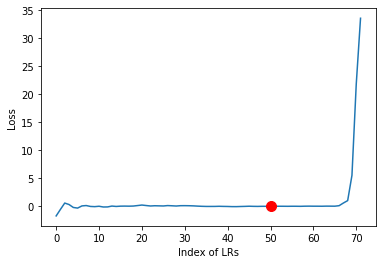

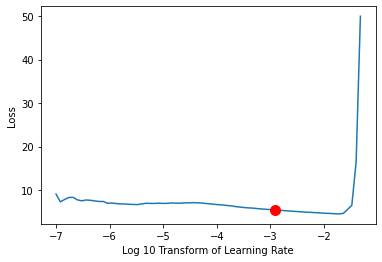

In [ ]:
lr = find_appropriate_lr(art_learn, plot=True)

In [ ]:
art_learn.fit_one_cycle(20, 1e-4, callbacks=[
    SaveModelCallback(art_learn, monitor='bleu_metric'),
    CSVLogger(art_learn, filename='art_train_img_cap_gen')
                                     ])

In [ ]:
art_learn.model.encoder.fine_tune(-1)

# for l in list(learn.model.encoder.children())[0]:
#     print(l, requires_grad(l))

#TESTING

In [ ]:
learn.model.eval();
data = test_data


In [ ]:
art_learn.model.eval();

In [ ]:
print(vocab.itos)

In [ ]:
k = 0;

a group of people are standing in the water .


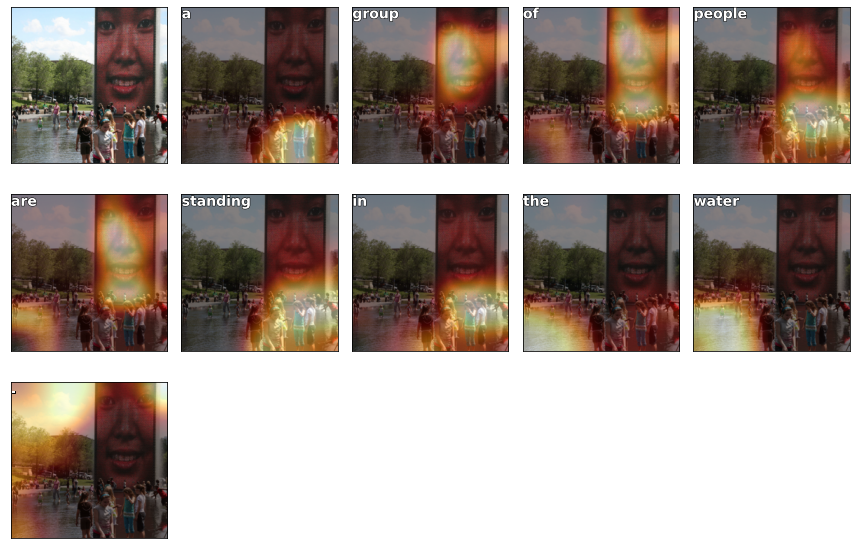

In [ ]:
beam_width = 5

beam_search = BeamSearch(learn.model.encode, learn.model.decode_step, beam_width)
im = learn.data.valid_ds[random.randint(0, 1000)][0]
# im = valid_tfms(Image.open('david2.jpg').convert('RGB'))
results = beam_search(im)
print(vocabolary.textify(results[0]))
visualize_attention(im, results[0], results[1], denorm, vocabolary, att_size=7, sz=sz, thresh=0.02)

a marble statue of a young woman with her hair and her hair


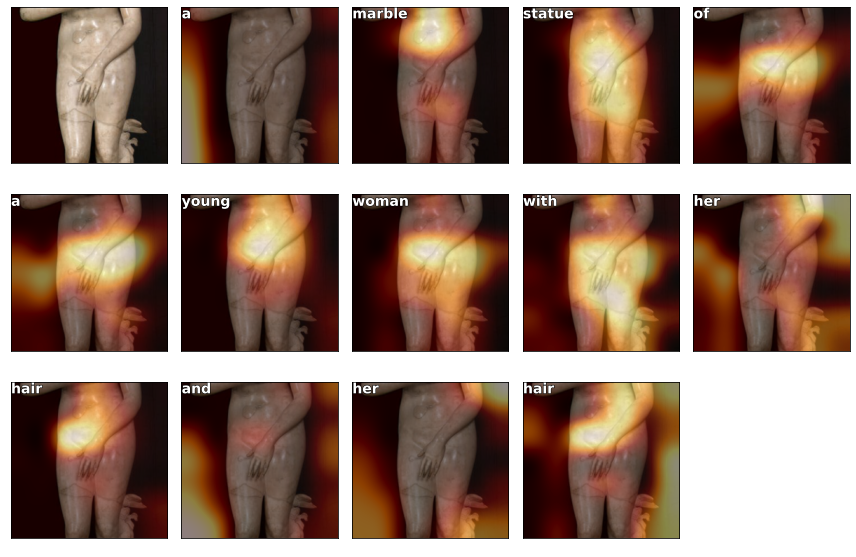

In [27]:
beam_width = 10

beam_search = BeamSearch(art_learn.model.encode, art_learn.model.decode_step, beam_width)
im = art_learn.data.valid_ds[random.randint(0, 25)][0]
# im = valid_tfms(Image.open('monnalisa.jpg').convert('RGB'))
results = beam_search(im)
print(vocabolary.textify(results[0]))
visualize_attention(im, results[0], results[1], denorm, vocabolary, att_size=7, sz=sz, thresh=0.02)

In [ ]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-5.0.1-cp36-none-any.whl size=18822 sha256=b0fab4b18f574a5c7fe9ba2a1ade1d987ca1bb4957a0952116dd5411703d51d6
  Stored in directory: /root/.cache/pip/wheels/94/01/05/d39efb8f6b40a411354b4168ca9dda99e6f8d586e458e97551
Successfully built pyngrok


In [ ]:
import os
import threading

from flask import *
from werkzeug.utils import secure_filename
from pyngrok import ngrok

os.environ["FLASK_ENV"] = "development"

UPLOAD_FOLDER = '/content/gdrive/My Drive/App/Art_Dataset'
ALLOWED_EXTENSIONS = {'txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'}

beam_width = 10

app = Flask(__name__)
port = 5000

app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

app.secret_key = b'bastianich'

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


@app.route('/', methods=['GET', 'POST'])
def upload_file():

    if request.method == 'POST':
        # check if the post request has the file part
        if 'image' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['image']
        # if user does not select file, browser also
        # submit an empty part without filename
        if file.filename == '':
            flash('No selected file')
            return redirect(request.url)
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(path)
        beam_search = BeamSearch(learn.model.encode, learn.model.decode_step, beam_width)
        image = valid_tfms(Image.open(path).convert('RGB'))
        results = beam_search(image)
        dictionary = {
            "caption": vocabolary.textify(results[0]),
            "beam_width": beam_width
        }
        return jsonify(dictionary)
        # beam_width = 5

        # beam_search = BeamSearch(learn.model.encode, learn.model.decode_step, beam_width)
        # im = learn.data.valid_ds[random.randint(0, 1000)][0]
        # # im = valid_tfms(Image.open('david2.jpg').convert('RGB'))
        # results = beam_search(im)
        # # print(vocabolary.textify(results[0]))
        # visualize_attention(im, results[0], results[1], denorm, vocabolary, att_size=7, sz=sz, thresh=0.02)
        # return vocabolary.textify(results[0])
    return jsonify({"data": "False"})


# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()

 * ngrok tunnel "http://01e43abe5859.ngrok.io" -> "http://127.0.0.1:5000"
 * Serving Flask app "__main__" (lazy loading)
 * Environment: development
 * Debug mode: on


In [ ]:
UPLOAD_FOLDER = '/content/drive/My Drive/App/Art_Dataset'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
path = os.path.join(app.config['UPLOAD_FOLDER'], "cane.jpg")